# Gradient basics

In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up

In [2]:
import DeepINN as dp

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


In [3]:
from torch import nn
import torch

# Test 1

In [4]:
x = torch.tensor([2.0], requires_grad = True)
print("x:", x)

y = x**2 + 1
print("y:", y)

x: tensor([2.], requires_grad=True)
y: tensor([5.], grad_fn=<AddBackward0>)


$$y=x^2 +1$$

$$\frac{dy}{dx} = 2x$$

In [5]:
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, x, create_graph=True, retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([4.], grad_fn=<MulBackward0>)


In [6]:
torch.autograd.grad(gradient, x, retain_graph=True)[0]

tensor([2.])

In [7]:
jacobian = dp.constraint.Jacobian(x, y)(0,0)
# jacobian_matrix = jacobian(0, 1)
jacobian

tensor([4.], grad_fn=<MulBackward0>)

In [8]:
dp.constraint.Jacobian(x, jacobian)(0,0)

tensor([2.], grad_fn=<MulBackward0>)

# A note for the future.
If we need to use the same graph to computer more gradients then we need to use retain_graph=True
We need to investigate whether we need this.

here we confirmed that both compute the same gradient. 

# 1D tensor with multiple values.

In [9]:
# Define a simple neural network for demonstration
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear = nn.Linear(2, 1) # automatic weights initialisation

    def forward(self, x):
        return self.linear(x)

In [10]:
# Create random input tensor
X = torch.tensor([1.0, 2.0], requires_grad=True)
X, X.size()

(tensor([1., 2.], requires_grad=True), torch.Size([2]))

In [11]:
# Instantiate the neural network
net = Net()

# Forward pass
y = net(X)
y

tensor([0.8279], grad_fn=<AddBackward0>)

In [12]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, X, retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([0.4486, 0.2921])


In [13]:
jacobian = dp.constraint.Jacobian(X, y)(0,0)
jacobian

tensor([0.4486, 0.2921], grad_fn=<SqueezeBackward1>)

Again we verified that dp and torch are giving the same results.

Let us do a manual forward prop for fun.

In [14]:
# Manually compute gradient
weights = net.linear.weight
biases = net.linear.bias

In [15]:
output = torch.matmul(X, weights.t()) + biases
y, output # notice both are same. ok I am stupid

(tensor([0.8279], grad_fn=<AddBackward0>),
 tensor([0.8279], grad_fn=<AddBackward0>))

# 2D tensor

In [16]:
# Create a 2D input tensor
X = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
print("X:\n", X)

X:
 tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [17]:
# Define a function that operates on the input tensor
def func(x):
    return torch.sin(x)

In [18]:
# Compute the output tensor
y = func(X)
print("y:\n", y)

y:
 tensor([[ 0.8415,  0.9093],
        [ 0.1411, -0.7568]], grad_fn=<SinBackward0>)


In [19]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, X, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([[ 0.5403, -0.4161],
        [-0.9900, -0.6536]])


In [20]:
# Instantiate the Jacobian module
jacobian = dp.constraint.Jacobian(X, y)

says the first column denotes x-coodinates and the the second column denotes the y-coordintes.

In [21]:
# dy/dx-coordinates, dy/dy-coordinates 
jacobian(0, 0), jacobian(0, 1)

(tensor([[ 0.5403],
         [-0.9900]], grad_fn=<IndexBackward0>),
 tensor([[-0.4161],
         [-0.6536]], grad_fn=<IndexBackward0>))

# Gradients with actual geometry

In [22]:
# Let us make a simple rectangle
X = dp.spaces.R2('x') #  2D space stencil
R = dp.domains.Parallelogram(X, [0,0], [1,0], [0,1])

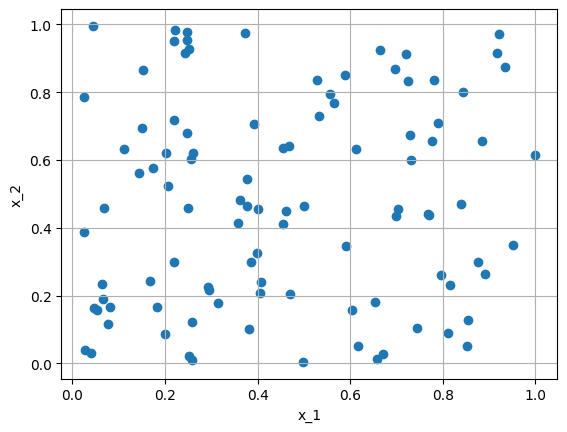

In [23]:
collocation_points = dp.samplers.RandomUniformSampler(R, n_points = 100)
dp.utils.scatter(X, collocation_points)

In [24]:
# sample collcocation points
collocation_points = dp.constraint.PDE(geom = R,
                                       sampling_strategy= "random",
                                       no_points = 100)

In [25]:
collocation_points_sampled = collocation_points.sampler_object().sample_points().as_tensor
collocation_points_sampled.size()

torch.Size([100, 2])

In [26]:
collocation_points_labels = collocation_points.sample_labels(collocation_points_sampled).unsqueeze(1)
collocation_points_labels.size()

torch.Size([100, 1])

In [27]:
import matplotlib.pyplot as plt

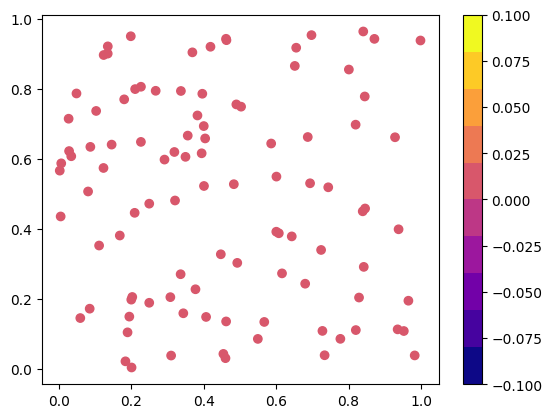

In [28]:
# The variation in BCs based on the provided function : lambda X: X[:,0]**2
plt.scatter(collocation_points_sampled[:,0], collocation_points_sampled[:,1], c = collocation_points_labels, cmap=plt.get_cmap('plasma',10))
plt.colorbar()

In [29]:
collocation_points_sampled.requires_grad = True # enable chain rule

# to differentiate a function, we need an actual function/neural network which take the collocation_points_sampled as the input and outputs the y
y = (collocation_points_sampled[:,0] ** 2).unsqueeze(1) + collocation_points_labels
y.size()

torch.Size([100, 1])

In [30]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, collocation_points_sampled, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([[1.3032, 0.0000],
        [1.6017, 0.0000],
        [0.6878, 0.0000],
        [0.9856, 0.0000],
        [0.8083, 0.0000],
        [0.4219, 0.0000],
        [1.4878, 0.0000],
        [0.0058, 0.0000],
        [1.6782, 0.0000],
        [0.2472, 0.0000],
        [1.9970, 0.0000],
        [0.8948, 0.0000],
        [1.2018, 0.0000],
        [0.6163, 0.0000],
        [1.6401, 0.0000],
        [0.4538, 0.0000],
        [1.5548, 0.0000],
        [1.6811, 0.0000],
        [0.7122, 0.0000],
        [0.9237, 0.0000],
        [1.4484, 0.0000],
        [0.1710, 0.0000],
        [0.7890, 0.0000],
        [1.0067, 0.0000],
        [1.2150, 0.0000],
        [1.3109, 0.0000],
        [0.6205, 0.0000],
        [1.7426, 0.0000],
        [1.9651, 0.0000],
        [0.8019, 0.0000],
        [0.4021, 0.0000],
        [0.6420, 0.0000],
        [1.1347, 0.0000],
        [0.5840, 0.0000],
        [1.2864, 0.0000],
        [0.9806, 0.0000],
        [1.6390, 0.0000],
        [1.2326, 0.0

In [31]:
# Instantiate the Jacobian module
jacobian = dp.constraint.Jacobian(collocation_points_sampled, y)

In [32]:
# dy/dx-coordinates, 
jacobian(i = 0, j = 0)

tensor([[1.3032],
        [1.6017],
        [0.6878],
        [0.9856],
        [0.8083],
        [0.4219],
        [1.4878],
        [0.0058],
        [1.6782],
        [0.2472],
        [1.9970],
        [0.8948],
        [1.2018],
        [0.6163],
        [1.6401],
        [0.4538],
        [1.5548],
        [1.6811],
        [0.7122],
        [0.9237],
        [1.4484],
        [0.1710],
        [0.7890],
        [1.0067],
        [1.2150],
        [1.3109],
        [0.6205],
        [1.7426],
        [1.9651],
        [0.8019],
        [0.4021],
        [0.6420],
        [1.1347],
        [0.5840],
        [1.2864],
        [0.9806],
        [1.6390],
        [1.2326],
        [1.9050],
        [0.6730],
        [1.1728],
        [1.8709],
        [0.4997],
        [0.4005],
        [0.3979],
        [1.0992],
        [0.0573],
        [0.4997],
        [1.9303],
        [0.1621],
        [0.4060],
        [0.9241],
        [1.4678],
        [0.2705],
        [0.9259],
        [0

In [33]:
#dy/dy-coordinates 
jacobian(i = 0, j = 1)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [38]:
hessian = dp.constraint.Jacobian(collocation_points_sampled, jacobian(i = 0, j = 1)
)

In [39]:
hessian(i = 0, j = 0)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [43]:
hessian(i = 0, j = 1)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      